In [ ]:
!pip install numpy_indexed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas
import ast
import os
from PIL import Image
import time
import copy
import numpy_indexed as npi

In [ ]:
a = np.asarray([[4, 6, 6],[4, 4, 4]])
b = np.asarray([[6, 6, 6,4],[4, 3, 2, 4]])
count = 0
for i in range(a.shape[0]):
  count += min(npi.in_(a[i, :], b[i, :]).sum(), npi.in_(b[i, :], a[i, :]).sum())
print(count)

5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Get parts list - use indices of each part as "label", for one-hot encoding
parts_list = []
with open('/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/BerendPartsList') as f:
  for line in f:
    word = line[:len(line) - 1] # get rid of '\n
    parts_list.append(int(word))

print(parts_list)

[4153825, 6104154, 6249125, 4210718, 4181135, 623224, 4621545, 4211166, 4121739, 6062574, 4567338, 4153827, 4539099, 306223, 6229071, 654126, 4550325, 4114319, 4165967, 4527943, 300424, 4181144, 6138173, 6177697, 6022023, 6028324, 6151663, 4121967, 4109995, 4211437, 4647553, 6035291, 306201, 4212454, 6073026, 4211201, 300401, 300421, 300821, 4529247, 4118793, 4504369, 6238674, 6069259, 6223631, 6022064, 300121, 300321, 300124, 4211614, 6225539, 300123, 4649749, 4651236, 4639693, 4157124, 4550348, 6244886, 6075079, 6025026, 4529240, 4558957, 4517992, 4548180, 614321, 6003007, 4211511, 4504381, 6252809, 4181134, 4211412, 300423, 4211149, 4650630, 6074890, 4160403, 4655172, 4211221, 4143562, 6075075, 6004938, 365901, 4211054, 4520632, 300323]


In [ ]:
csv_path = '/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/Berend/CSV/labels.csv'
image_path = '/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/Berend/Images'
bbox_label_root = '/content/drive/My Drive/APS360 Project/finalOutput'
data = pandas.read_csv(csv_path)
# Convert label col to list of ints of part numbers:
for i in range(len(data["Labels"])):
  label = data["Labels"][i]
  list_row = ast.literal_eval(label)
  data["Labels"][i] = list(map(int, list_row))
# Do same for Color column:
for i in range(len(data["Color"])):
  label = data["Color"][i]
  list_row = ast.literal_eval(label)
  data["Color"][i] = list(map(int, list_row))
print(data["Name"][707])

B_710


In [ ]:
# Let us only deal with the first 10 data points:
data_subset = data[:10]
print(data_subset)

  Name     Light  ...            Color                                Labels
0  B_0  daylight  ...  [130, 130, 130]                             [4650630]
1  B_1  daylight  ...  [130, 130, 130]                             [4650630]
2  B_2  daylight  ...  [130, 130, 130]                             [4650630]
3  B_3  daylight  ...  [130, 130, 130]                    [4650630, 6252809]
4  B_4  daylight  ...  [130, 130, 130]                    [4650630, 6252809]
5  B_5  daylight  ...  [130, 130, 130]                    [4650630, 6252809]
6  B_6  daylight  ...  [130, 130, 130]           [4650630, 6252809, 4211054]
7  B_7  daylight  ...  [130, 130, 130]           [4650630, 6252809, 4211054]
8  B_8  daylight  ...  [130, 130, 130]           [4650630, 6252809, 4211054]
9  B_9  daylight  ...  [130, 130, 130]  [4650630, 6252809, 4211054, 4548180]

[10 rows x 5 columns]


In [ ]:
label = data_subset["Name"][9]
print(label)
columns = ["Labels", "x_min", "y_min", "x_max", "y_max"]
bboxes = pandas.read_csv(os.path.join(bbox_label_root, label + '.csv'), skiprows=2, header=None, names=columns)
bboxes_np = bboxes.to_numpy()
print(bboxes_np)
print(type(bboxes_np[0, 0]))

B_9
[[6252809    1393    1643    2467    2598]
 [4548180    2619    1789    2910    2023]
 [4211054    2897    2497    3295    2769]
 [4650630    1551     209    1797     392]]
<class 'numpy.int64'>


In [ ]:
class BerendDataset(Dataset):
  # For our dataset, let us accept a CSV file as input
  # + a list of parts, for a one-hot encoding.
  # We will also accept a root directory for images. 
  # We also accept transformations to the image
  def __init__(self, csv_path, parts_list, image_root, transforms, bbox_root):
    self.csv_path = csv_path
    self.parts_list = parts_list
    self.image_root = image_root
    data = pandas.read_csv(csv_path)
    # Convert label col to list of ints of part numbers:
    for i in range(len(data["Labels"])):
      label = data["Labels"][i]
      list_row = ast.literal_eval(label)
      int_list = list(map(int, list_row))
      data["Labels"][i] = list(map(lambda x: parts_list.index(x), int_list))

    # Do same for Color column:
    for i in range(len(data["Color"])):
      label = data["Color"][i]
      list_row = ast.literal_eval(label)
      data["Color"][i] = torch.LongTensor(list(map(int, list_row)))
    
    self.data = data
    self.transforms = transforms
    self.bbox_root = bbox_root
    self.bbox_tracked = {}
    self._BBOX_COL_NAMES = ["Labels", "x_min", "y_min", "x_max", "y_max"]

  def __getitem__(self, idx):
    target = {}
    labels = self.data["Labels"][idx]

    filename = self.data["Name"][idx]
    #print(filename)
    img_path = os.path.join(self.image_root, filename + '.jpg')
    bbox_path = os.path.join(self.bbox_root, filename + '.csv')

    img = Image.open(img_path).convert("RGB")
    if self.transforms is not None:
      img = self.transforms(img)

    target["labels"] = torch.LongTensor(labels)

    if filename in self.bbox_tracked:
      bboxes = self.bbox_tracked[filename]
    else:
      bbox_data = pandas.read_csv(os.path.join(self.bbox_root, filename + '.csv'),
                                  skiprows=2,
                                  header=None,
                                  names=self._BBOX_COL_NAMES)
      bbox_data_np = bbox_data.to_numpy(dtype=np.int_)
      #print("1st = ", bbox_data_np)
      bbox_labels = bbox_data_np[:, 0]
      #print("2nd = ", bbox_labels)
      bbox_targets = bbox_data_np[:, 1:]
      #print("3rd = ", bbox_targets)
      temp = []
      scalex = 330/3072
      scaley = 550/4608
      for b in bbox_targets:
        abox = []
        abox.append(b[0]*scalex)
        abox.append(b[1]*scaley)
        abox.append(b[2]*scalex)
        abox.append(b[3]*scaley)
        temp.append(abox)
      bbox_targets = temp
      #print("mine = ", bbox_targets)
      bboxes = torch.zeros([len(labels), 4], dtype=torch.long)
      #print("4th = ", bboxes)
      for i in range(len(bbox_labels)):
        bboxes[i, :] = torch.LongTensor(bbox_targets[i])
      #print("5th = ", bboxes)
      self.bbox_tracked[filename] = bboxes

    target["boxes"] = bboxes
    
    return img, target
  def __len__(self):
        return len(self.data)

In [ ]:
data_transform = transforms.Compose([transforms.Resize((375, 500)), transforms.ToTensor()])
dataset = BerendDataset(csv_path=csv_path, parts_list=parts_list, image_root=image_path, transforms=data_transform, bbox_root=bbox_label_root)

In [ ]:
item = dataset[9]

(tensor([[[0.3020, 0.3059, 0.3020,  ..., 0.3529, 0.3647, 0.3922],
         [0.3490, 0.3647, 0.3412,  ..., 0.3529, 0.3843, 0.4157],
         [0.3490, 0.3686, 0.3765,  ..., 0.3882, 0.3961, 0.3843],
         ...,
         [0.4706, 0.4980, 0.5098,  ..., 0.4510, 0.4510, 0.4627],
         [0.4667, 0.4784, 0.4941,  ..., 0.4510, 0.4510, 0.4667],
         [0.4471, 0.4667, 0.4588,  ..., 0.4549, 0.4549, 0.4667]],

        [[0.2706, 0.2627, 0.2588,  ..., 0.3176, 0.3255, 0.3451],
         [0.3137, 0.3176, 0.3098,  ..., 0.3059, 0.3294, 0.3686],
         [0.3098, 0.3216, 0.3451,  ..., 0.3412, 0.3569, 0.3608],
         ...,
         [0.5412, 0.5765, 0.5725,  ..., 0.4549, 0.4549, 0.4549],
         [0.5294, 0.5647, 0.5490,  ..., 0.4471, 0.4471, 0.4667],
         [0.4824, 0.5176, 0.5137,  ..., 0.4471, 0.4392, 0.4588]],

        [[0.1608, 0.1647, 0.1529,  ..., 0.2706, 0.2667, 0.3020],
         [0.1922, 0.2118, 0.1843,  ..., 0.2549, 0.2902, 0.3294],
         [0.1961, 0.2039, 0.2000,  ..., 0.2667, 0.3020, 0

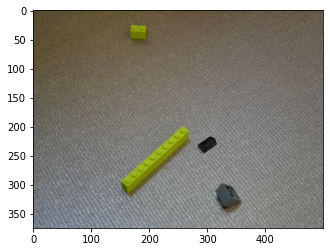

In [ ]:
print(item)
image, target = item
img = np.transpose(image, [1,2,0])
print(img.shape)
plt.imshow(img)
print(target["boxes"])

tensor([149, 196, 265, 310])
tensor([281, 213, 312, 241])
tensor([311, 298, 353, 330])
tensor([166,  24, 193,  46])


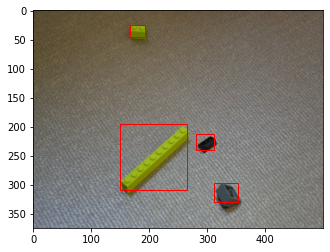

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from torchvision import transforms

im = transforms.ToPILImage()(image).convert("RGB")

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

for b in target["boxes"]:
  print(b)
  # Create a Rectangle patch
  rect = patches.Rectangle((b[0],b[1]),(b[2]-b[0]), (b[3]-b[1]),linewidth=1,edgecolor='r',facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)

plt.show()


In [ ]:
print(len(dataset))

816


In [ ]:
import torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.num_classes = len(parts_list)
print(model)
image = image.unsqueeze(0)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample

In [ ]:
model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=len(parts_list), bias=True)
model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024, out_features=4*len(parts_list), bias=True)

In [ ]:
model.eval()
out = model(image)

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


In [ ]:
print(out)

[{'boxes': tensor([[170.1227, 180.1349, 272.8784, 334.4769],
        [152.7541, 255.2456, 249.6146, 308.6491],
        [340.2532, 314.7879, 351.5516, 323.7848],
        [332.0996, 312.2815, 360.6966, 343.7767],
        [325.5358, 316.7453, 341.2369, 330.9194],
        [289.4668, 217.8433, 319.5322, 245.7594],
        [322.4462, 305.5647, 366.0512, 333.3948],
        [175.1193, 241.3795, 254.8701, 281.3550],
        [192.1996, 206.9125, 271.9513, 288.7838],
        [336.8053, 307.1487, 355.7149, 326.4111],
        [291.0573, 222.3794, 314.1515, 240.0918],
        [336.2328, 314.9727, 352.0157, 331.6801],
        [328.9142, 319.0598, 337.3234, 329.9635],
        [339.5835, 312.5913, 347.9953, 321.7216],
        [328.8183, 315.2779, 337.4221, 326.4009],
        [288.4858, 218.1115, 311.6465, 234.9827],
        [313.6641, 291.1595, 367.4854, 356.7339],
        [122.6632, 204.8000, 305.3979, 323.1198],
        [337.5270, 316.3922, 346.6607, 323.9902],
        [341.5880, 313.8326, 356.7237, 

In [ ]:
model.train()
img, label = dataset[3]
img = img.unsqueeze(0)
label = [label]
print(img.shape)
print(label)



torch.Size([1, 3, 375, 500])
[{'labels': tensor([73, 68]), 'boxes': tensor([[213,  94, 246, 128],
        [169, 190, 321, 282]])}]


In [ ]:
out = model(img, label)

In [ ]:
print(out)

{'loss_classifier': tensor(4.8393, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.1955, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0370, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0085, grad_fn=<DivBackward0>)}


In [ ]:
out['loss_classifier'].backward()

In [ ]:
train_length = int(0.6*len(dataset))
val_length = int(0.2*len(dataset))
#train_length = 20
#val_length = 20
test_length = len(dataset) - train_length - val_length
torch.manual_seed(42)
trainset, valset, testst = torch.utils.data.random_split(dataset,
                                                         [train_length, val_length, test_length])

In [ ]:
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=32)

In [ ]:
def collate_fn(batch):
  images = []
  targets = []
  for lego in batch:
    images.append(lego[0])
    targets.append(lego[1])
  
  return images, targets



In [ ]:
class Batcher:
    def __init__(self, dataset, batch_size=32, drop_last=False):
        self.pics_by_length = {}
        for image, target in dataset:
            # compute the length of the labels:
            llen =target["labels"].shape[0]
            # put the data in the correct key inside self.tweet_by_length
            if llen not in self.pics_by_length:
                self.pics_by_length[llen] = []
            self.pics_by_length[llen].append((image, target),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {llen : torch.utils.data.DataLoader(
                                    legos,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last,   # omit last batch if smaller than batch_size
                                    collate_fn=collate_fn)
            for llen, legos in self.pics_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

In [ ]:
trainloader = Batcher(trainset, batch_size=3, drop_last=True)
'''
for i, (image, target) in enumerate(Batcher(trainset,zy drop_last=True)):
    if i >= 0:
      print(image.shape, target) 
      break
'''

'\nfor i, (image, target) in enumerate(Batcher(trainset,zy drop_last=True)):\n    if i >= 0:\n      print(image.shape, target) \n      break\n'

In [ ]:
val_loader = Batcher(valset, batch_size=3, drop_last=True)

In [ ]:
'''for images, target in val_loader.loaders[1]:
  model = model.cuda()
  for i in range(len(images)):
    inputs[i] = inputs[i].cuda()
    target[i]["labels"] = target[i]["labels"].cuda()
    target[i]["boxes"] = target[i]["boxes"].cuda()
  out = model(images, target)
  break'''

'for images, target in val_loader.loaders[1]:\n  model = model.cuda()\n  for i in range(len(images)):\n    inputs[i] = inputs[i].cuda()\n    target[i]["labels"] = target[i]["labels"].cuda()\n    target[i]["boxes"] = target[i]["boxes"].cuda()\n  out = model(images, target)\n  break'

In [ ]:
#print(out)

In [ ]:
def get_metrics(model, dataloader):
  model.eval()
  count = 0
  total_predictions = 0
  total_labels = 0
  for inputs, target in dataloader:
    for i in range(len(inputs)):
      inputs[i] = inputs[i].cuda()
      target[i]["labels"] = target[i]["labels"].cuda()
      target[i]["boxes"] = target[i]["boxes"].cuda()
  
    outputs = model(inputs)
    for i in range(len(outputs)):
      label = (target[i]["labels"]).cpu().numpy()
      pred = outputs[i]['labels'].cpu().numpy()
      # Get number of true positives:
      count += min(npi.in_(pred, label).sum(), npi.in_(label, pred).sum())
      # Get total number of predictions:
      total_predictions += len(pred)
      total_labels += len(label)
      # print(label, pred)
  # Precisions = TP/(TP + FP)
  if (total_predictions == 0):
    precision = 0
  else:
    precision = count/total_predictions

  if (total_labels == 0):
    recall = 0
  else:
    recall = count/total_labels
  return (precision, recall)

In [ ]:
def train_model(model, optimizer, trainloader, val_loader, num_epochs=25):
    torch.manual_seed(42)
    since = time.time()

    epochs, train_loss, train_precs, train_recalls, val_precs, val_recalls = [], [], [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        n = 0
        for inputs, target in trainloader:
            for i in range(len(inputs)):
              inputs[i] = inputs[i].cuda()
              target[i]["labels"] = target[i]["labels"].cuda()
              target[i]["boxes"] = target[i]["boxes"].cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs, target)
                #preds = torch.max(outputs, 1)
                class_loss = outputs['loss_classifier']

                class_loss.backward()
                optimizer.step()
                # statistics
                running_loss += class_loss.item()
                #running_corrects += torch.sum(preds == target)
                n+=1
            #print("Epoch {}, iteration {}".format(epoch, n))
                  

        torch.set_grad_enabled(False)
        epoch_loss = running_loss / n
        train_loss.append(epoch_loss)
        epochs.append(epoch)
        train_prec, train_recall = get_metrics(model, trainloader)
        val_prec, val_recall = get_metrics(model, val_loader)
        train_precs.append(train_prec)
        val_precs.append(val_prec)
        train_recalls.append(train_recall)
        val_recalls.append(val_recall)

        print('Training - {} Loss: {:.4f} Prec: {:.4f} Recall: {:.4f}'.format(epoch, epoch_loss, train_prec, train_recall))
        print('Validation - {} Prec: {:.4f} Recall: {:.4f}'.format(epoch, val_prec, val_recall))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    """
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    """
    # plotting
    plt.title("Training Loss Curve")
    plt.plot(epochs, train_loss, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Precision Curve")
    plt.plot(epochs, train_precs, label="Train")
    plt.plot(epochs, val_precs, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Recall Curve")
    plt.plot(epochs, train_recalls, label="Train")
    plt.plot(epochs, val_recalls, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend(loc='best')
    plt.show()
    return model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters(), lr=1e-5)
model = model.cuda()

Epoch 0/19
----------
Training - 0 Loss: 0.8794 Prec: 0.0000 Recall: 0.0000
Validation - 0 Prec: 0.0000 Recall: 0.0000

Epoch 1/19
----------
Training - 1 Loss: 0.6142 Prec: 0.1676 Recall: 0.0592
Validation - 1 Prec: 0.1345 Recall: 0.0395

Epoch 2/19
----------
Training - 2 Loss: 0.6413 Prec: 0.0572 Recall: 0.2195
Validation - 2 Prec: 0.0448 Recall: 0.1598

Epoch 3/19
----------
Training - 3 Loss: 0.6408 Prec: 0.0477 Recall: 0.5842
Validation - 3 Prec: 0.0446 Recall: 0.5326

Epoch 4/19
----------
Training - 4 Loss: 0.5733 Prec: 0.0463 Recall: 0.7471
Validation - 4 Prec: 0.0384 Recall: 0.6667

Epoch 5/19
----------
Training - 5 Loss: 0.4468 Prec: 0.0462 Recall: 0.8295
Validation - 5 Prec: 0.0399 Recall: 0.7921

Epoch 6/19
----------
Training - 6 Loss: 0.3268 Prec: 0.0528 Recall: 0.8569
Validation - 6 Prec: 0.0430 Recall: 0.7938

Epoch 7/19
----------
Training - 7 Loss: 0.2203 Prec: 0.0650 Recall: 0.9029
Validation - 7 Prec: 0.0529 Recall: 0.8333

Epoch 8/19
----------
Training - 8 Loss:

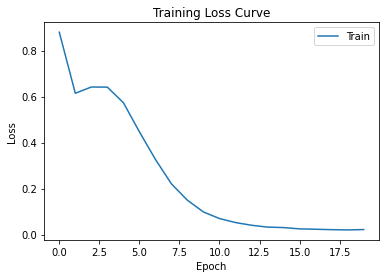

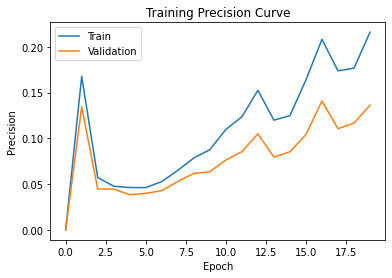

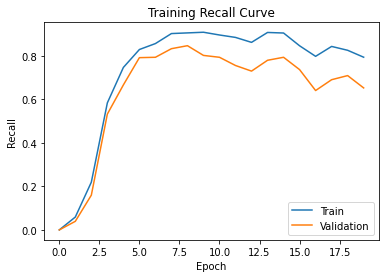

In [ ]:
model_ft = train_model(model, optimizer_ft, trainloader, val_loader,
                       num_epochs=20)

635
tensor([[128.5180,  90.3234, 276.3253, 135.9081],
        [126.7914, 254.5665, 182.6079, 324.9783],
        [278.3904, 251.6803, 316.5118, 303.3420],
        [161.9465, 104.0369, 213.6585, 206.2260],
        [248.0809, 192.3507, 347.4695, 307.8331],
        [180.8134, 104.8182, 202.8342, 210.6110],
        [111.3220, 284.8716, 211.2527, 357.8428],
        [331.2018, 206.6536, 340.2990, 240.7231],
        [326.0118, 188.5882, 334.2623, 239.5373],
        [151.7040, 297.1541, 227.6861, 356.3878],
        [272.7676, 224.4767, 345.1159, 265.3081]], device='cuda:0')
[63, 53, 8, 63, 60, 63, 63, 70, 70, 49, 4]


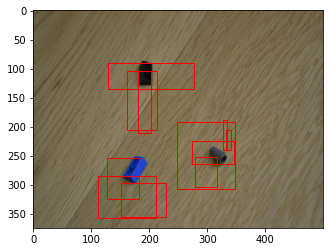

In [ ]:
model.eval()
#6227
rand_ind = np.random.randint(len(dataset))
print(rand_ind)
item = dataset[401]
image, target = item
image = image.unsqueeze(0)
out = model(image.cuda())
image = image.squeeze(0)
im = transforms.ToPILImage()(image).convert("RGB")
print(out[0]["boxes"])
label = out[0]["labels"].tolist()
print(label)
fig,ax = plt.subplots(1)
ax.imshow(im)
for a, b in enumerate(out[0]["boxes"]):
  #print(label[a])
  if label[a] == 53 or label[a] == 60 or label[a] == 63:
    pass
  # Create a Rectangle patch
  rect = patches.Rectangle((b[0],b[1]),(b[2]-b[0]), (b[3]-b[1]),linewidth=1,edgecolor='r',facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)


tensor([63, 53, 60])
tensor([[181,  88, 203, 125],
        [153, 244, 194, 290],
        [301, 227, 330, 259]])


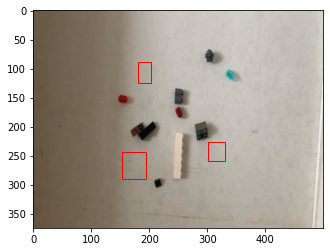

In [ ]:
item = dataset[401]
image, target = item
img = np.transpose(image, [1,2,0])
print(target["labels"])
fig,ax = plt.subplots(1)
ax.imshow(im)
print(target["boxes"])
label = target["labels"].tolist()
for a, b in enumerate(target["boxes"]):
  rect = patches.Rectangle((b[0],b[1]),(b[2]-b[0]), (b[3]-b[1]),linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)

[36, 36, 36, 36, 82, 82, 36, 15, 77, 52, 10, 72, 2, 84, 77, 77, 84, 77, 2, 84, 15, 6, 44, 12, 40, 48, 72, 66, 60]


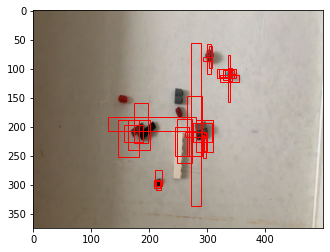

In [ ]:
data_transform = transforms.Compose([transforms.Resize((375, 500)), transforms.ToTensor()])
newdata = Image.open("/content/drive/My Drive/APS360 Project/new_data.jpg").convert("RGB")
newdata = data_transform(newdata)
model.eval()
newdata = newdata.unsqueeze(0)
out = model(newdata.cuda())
newdata = newdata.squeeze(0)
im = transforms.ToPILImage()(newdata).convert("RGB")
label = out[0]["labels"].tolist()
print(label)
fig,ax = plt.subplots(1)
ax.imshow(im)
for a, b in enumerate(out[0]["boxes"]):
  rect = patches.Rectangle((b[0],b[1]),(b[2]-b[0]), (b[3]-b[1]),linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)


In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/APS360 Project/Models/RCNN/weights_e201")

In [ ]:
def eval_model(model, testloader):
    torch.manual_seed(42)
    since = time.time()

    epochs, train_loss, train_precs, train_recalls, val_precs, val_recalls = [], [], [], [], [], []
    model.eval()

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    n = 0
    for inputs, target in trainloader:
        for i in range(len(inputs)):
          inputs[i] = inputs[i].cuda()
          target[i]["labels"] = target[i]["labels"].cuda()
          target[i]["boxes"] = target[i]["boxes"].cuda()

    torch.set_grad_enabled(False)
    test_prec, test_recall = get_metrics(model, testloader)
    print('Testing Results Prec: {:.4f} Recall: {:.4f}'.format(test_prec, test_recall))
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [ ]:
test_loader = Batcher(testst, batch_size=3, drop_last=True)

In [ ]:
eval_model(model, test_loader)

Testing Results Prec: 0.1328 Recall: 0.5980

Training complete in 0m 20s


In [ ]:
import torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=len(parts_list), bias=True)
model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024, out_features=4*len(parts_list), bias=True)
model.load_state_dict(torch.load("/content/drive/My Drive/APS360 Project/Models/RCNN/weights_e20"))

<All keys matched successfully>

In [ ]:
data_transform = transforms.Compose([transforms.Resize((375, 500)), transforms.ToTensor()])
newdata = Image.open("/content/drive/My Drive/APS360 Project/new_data.jpg").convert("RGB")
newdata = data_transform(newdata)

In [ ]:
model.eval()
model.cuda()
newdata = newdata.unsqueeze(0)
out = model(newdata.cuda())
newdata = newdata.squeeze(0)

36 :  300401
82 :  4211054
15 :  654126
77 :  4211221
52 :  4649749
10 :  4567338
72 :  4211149
2 :  6249125
84 :  300323
6 :  4621545
44 :  6223631
12 :  4539099
40 :  4118793
48 :  300124
66 :  4211511
60 :  4529240


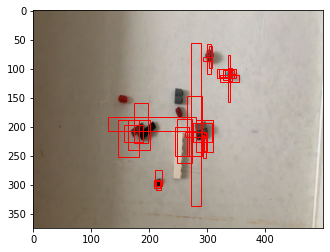

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from torchvision import transforms

im = transforms.ToPILImage()(newdata).convert("RGB")
label = out[0]["labels"].tolist()
parts_found = []
for i, ind in enumerate(label):
  if (label[i], parts_list[ind]) not in parts_found:
    print(label[i], ": ", parts_list[ind])
    parts_found.append((label[i], parts_list[ind]))

fig,ax = plt.subplots(1)
ax.imshow(im)
for a, b in enumerate(out[0]["boxes"]):
  rect = patches.Rectangle((b[0],b[1]),(b[2]-b[0]), (b[3]-b[1]),linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)


In [ ]:
for i, tup in enumerate(parts_found):
  im = transforms.ToPILImage()(newdata).convert("RGB")
  fig, ax = plt.subplots(1)
  for a, b in enumerate(out[0]["boxes"]):
    if label[a] == tup[0]:
      rect = patches.Rectangle((b[0],b[1]),(b[2]-b[0]), (b[3]-b[1]),linewidth=1,edgecolor='r',facecolor='none')
      ax.add_patch(rect)
  ax.imshow(im)